In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 未增频

In [19]:
# read data
data = pd.read_csv("mbd_updated.csv").iloc[:, :-3]

# calculate return
ret = (data.shift(-1)['idt_price'] - data['idt_price']) / data['idt_price']
ret[659] = 0
sign = [0 if r < 0 else 1 for r in ret]

# append to data
data['return'] = ret
data['sign'] = sign

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data[['sd', 'kurt']]).T
price = scaler.fit_transform(data[['idt_price', 'mu']]).T

In [26]:
# calculate rolling mean
def rolling_mean(arr, window):
    weights = np.ones(window) / window
    return np.convolve(arr, weights, mode='valid')

kurt = rolling_mean(normalized_data[1], 20)
sd = rolling_mean(normalized_data[0], 20)
total = kurt - sd

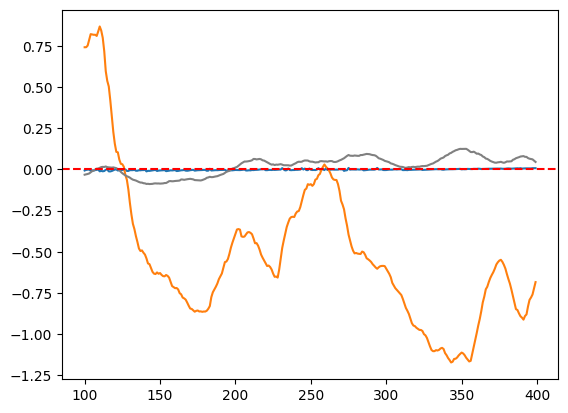

In [22]:
a = 100
b = a + 300
x = list(range(a, b))
# plt.plot(data['return'][a:b])
plt.plot(data['mu'][a:b])
plt.plot(x, sd[a:b])
plt.plot(x, kurt[a:b]/10, color='gray')
# plt.plot(data['p90'][:100])
plt.axhline(y=0, color='r', linestyle='--')

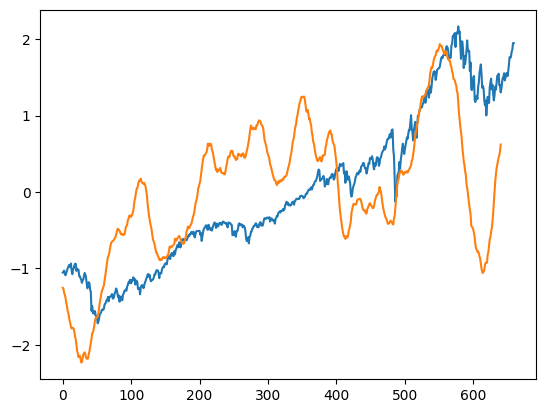

In [29]:
plt.plot(price[0])
plt.plot(kurt)
# plt.plot(sd)
# plt.plot(total)

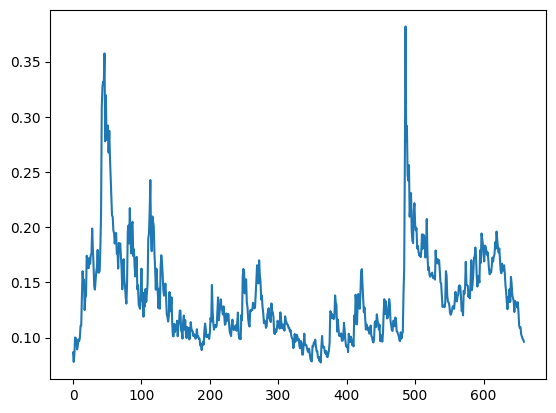

In [30]:
plt.plot(data['sd'])

In [24]:
np.array(price[0])

array([-1.05185337, -1.04466846, -1.02690226, -1.07472837, -1.08863888,
       -1.06129611, -1.03069092, -1.00244878, -0.98444353, -0.95628746,
       -0.95409655, -0.982377  , -0.93535461, -1.02837564, -1.07484317,
       -1.01046603, -1.00065016, -0.95998993, -0.93898058, -0.93833955,
       -1.03231728, -1.00362552, -1.0162446 , -1.01585232, -1.09947849,
       -1.10177451, -1.12909824, -1.14762016, -1.18827081, -1.15520693,
       -1.14398461, -1.09503934, -1.05870346, -1.08088954, -1.11949282,
       -1.19605846, -1.25833077, -1.20813215, -1.17864636, -1.19335101,
       -1.27957941, -1.30477915, -1.55210813, -1.49383487, -1.58516256,
       -1.56320602, -1.58967821, -1.55649946, -1.61343337, -1.63052022,
       -1.62960175, -1.71738002, -1.69684903, -1.65731771, -1.60547352,
       -1.58562176, -1.57598767, -1.54129731, -1.53691561, -1.54112511,
       -1.52834346, -1.47591568, -1.46002466, -1.44421026, -1.41358592,
       -1.4093286 , -1.37155753, -1.42931431, -1.37450428, -1.37

In [25]:
np.corrcoef(np.array(price[0]), np.array(total))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 660 and the array at index 1 has size 641

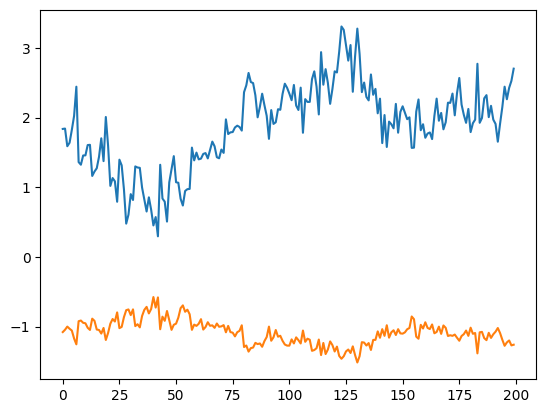

In [ ]:
plt.plot(data['kurt'][:200])
plt.plot(data['skew'][:200])

In [ ]:
# seperate to training sets and testing sets
X = data.iloc[:, 5:-2]
y = data.iloc[:, -1]
X_train = data.iloc[:400, 5:-2]
y_train = data.iloc[:400, -1]
X_test = data.iloc[400:, 5:-2]
y_test = data.iloc[400:, -1]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# create a logistic regression model: binary 1 (+ return) or 0 (- return)
scaler = StandardScaler()
clf = LogisticRegression(solver="liblinear", class_weight={0:1.4, 1:1})
name = "logistic_regression"
model_pipeline = Pipeline([("scaler", scaler), (name, clf)])

# fit moel
_ = model_pipeline.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

accuracy_score(y_train, model_pipeline.predict(X_train))

0.5725

In [ ]:
confusion_matrix(y_train, model_pipeline.predict(X_train))

array([[ 70,  89],
       [ 82, 159]], dtype=int64)

In [ ]:
accuracy_score(y_test, model_pipeline.predict(X_test))

0.5538461538461539

In [ ]:
confusion_matrix(y_test, model_pipeline.predict(X_test))

array([[  6,  88],
       [ 28, 138]], dtype=int64)

In [ ]:
accuracy_score(y, model_pipeline.predict(X))

0.5651515151515152

In [ ]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M
M = transition_matrix(data['sign'])
M

[[0.3794466403162055, 0.6205533596837944],
 [0.3866995073891626, 0.6133004926108374]]

In [ ]:
# create threshold for each trading opportunity
threshold = [M[0][0]]
for i in range(1, len(sign)):
    if sign[i] == 0:
        threshold.append(M[0][0])
    else:
        threshold.append(M[1][0])

In [ ]:
y_train_pred = []
for p, t in zip(model_pipeline.predict_proba(X_train), threshold):
    if p[1] > t:
        y_train_pred.append(1)
    else:
        y_train_pred.append(0)

In [ ]:
confusion_matrix(y_train, y_train_pred)

array([[  3, 156],
       [  0, 241]], dtype=int64)

In [ ]:
sum(y_train)

241

# 增频

In [ ]:
# S&P 500 Data
sp500 = pd.read_csv('sp500_data.csv', index_col='Date')
sp500.index = pd.to_datetime(sp500.index)

# Market-based Density Data
mbd = pd.read_csv('data\sp6m_6.csv', index_col='idt').iloc[:, 1:]
mbd.index = pd.to_datetime(mbd.index)

# risk-free rate
rf = pd.read_csv(r'data\risk_free.csv', index_col='DATE')
rf.index = pd.to_datetime(rf.index)

In [ ]:
# increase the frequency of the mbd dataset, and get the close column
data = sp500.loc[pd.to_datetime('2007-01-12'):, ['Close']].join(mbd).ffill()
close = data['Close']
data = data[data.columns[1:]]

# calculate return 
ret = (close.shift(1) - close) / close
ret.iloc[0] = 0

# mark +/- for return
sign = [1 if r > 0 else 0 for r in ret]

# append return and return sign to data frame
data['return'] = ret
data['+\-'] = sign

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# seperate data into testing set and training set
X_train = data.loc[:pd.to_datetime('2022-01-03'), data.columns[2:-2]]
y_train = data.loc[:pd.to_datetime('2022-01-03'), data.columns[-1]]
X_test = data.loc[pd.to_datetime('2022-01-03'):, data.columns[2:-2]]
y_test = data.loc[pd.to_datetime('2022-01-03'):, data.columns[-1]]

# create a logistic regression model: binary 1 (+ return) or 0 (- return)
scaler = StandardScaler()
clf = LogisticRegression(solver="liblinear", class_weight={0:1, 1:1.22})
name = "logistic_regression"
model_pipeline = Pipeline([("scaler", scaler), (name, clf)])
_ = model_pipeline.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

score_out_of_sample = accuracy_score(y_train, model_pipeline.predict(X_train))
score_out_of_sample

0.4972155926809865

In [ ]:
confusion_matrix(y_train, model_pipeline.predict(X_train))

array([[1081,  989],
       [ 907,  794]], dtype=int64)

In [ ]:
confusion_matrix(y_test, model_pipeline.predict(X_test))

array([[188,  68],
       [180,  84]], dtype=int64)

In [ ]:
model_pipeline.predict_proba(X_train)[:100]

array([[0.49855301, 0.50144699],
       [0.49855301, 0.50144699],
       [0.49855301, 0.50144699],
       [0.49855301, 0.50144699],
       [0.49855301, 0.50144699],
       [0.49855301, 0.50144699],
       [0.49855301, 0.50144699],
       [0.49855301, 0.50144699],
       [0.49855301, 0.50144699],
       [0.49855301, 0.50144699],
       [0.49855301, 0.50144699],
       [0.49855301, 0.50144699],
       [0.49555908, 0.50444092],
       [0.49555908, 0.50444092],
       [0.49555908, 0.50444092],
       [0.49555908, 0.50444092],
       [0.49555908, 0.50444092],
       [0.49555908, 0.50444092],
       [0.49555908, 0.50444092],
       [0.49555908, 0.50444092],
       [0.49555908, 0.50444092],
       [0.49555908, 0.50444092],
       [0.49555908, 0.50444092],
       [0.49692769, 0.50307231],
       [0.49692769, 0.50307231],
       [0.49692769, 0.50307231],
       [0.49692769, 0.50307231],
       [0.49692769, 0.50307231],
       [0.49692769, 0.50307231],
       [0.49692769, 0.50307231],
       [0.

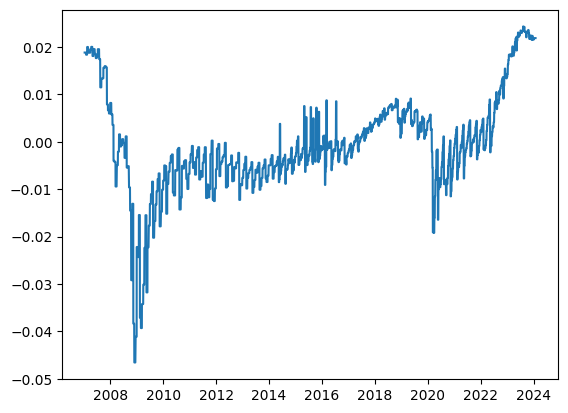

In [ ]:
plt.plot(data['mu'])